## packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

### Read grid and masks

In [2]:
# define basin we want
iB = 6   # see mskBasin if you want for later; maybe we should write this to file

In [3]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"

In [4]:
bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

In [5]:
# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Heat'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'SEAICEheatConsFix': 0,
    'conserveTr': 0
    
}

deltaTime = myparms['timeStep']
dt = 86400

In [6]:
# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

In [7]:
# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

(50,) (50, 1350, 270)


In [8]:
#mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

hf1 (1350, 270)


In [9]:
# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

(50, 1350, 270)

### Get timesteps

In [10]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
times["2014"] = np.arange(3,5,1)
# times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

t2 = int(tsstr[1])

### heat tendency

In [11]:
# ocean and ice
AB_gT=0
AB_gS=0
debug = False

In [12]:
# ffac = 1e-6
ffac = 1

In [13]:
dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()

In [15]:
# read thetadr
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["THETADR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisTHETADR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisTHETADR = thisTHETADR.reshape(nz,ny,nx)
    THETADR[i] = thisTHETADR

THETADR =  (THETADR[1, :, :,:] - THETADR[0, :,:, :]) / dt    # degC.m/s

In [16]:
tmptend=myparms['rcp']*(THETADR-AB_gT)*mk3D_mod(RAC,THETADR)   # J/m^3.degC * degC.m/s * m^2 = J/s
budgO = {}
budgI = {}
budgOI = {}
budgO['fluxes'] = {}
budgI['fluxes'] = {}

budgO['fluxes']['tend'] = tmptend     # J/s

budgO['tend'] = np.nansum(tmptend,axis=0)
# budgI['tend'] = -myparms['flami'] * (SIheff*myparms['rhoi'] + SIhsnow*myparms['rhosn']) * RAC
# budgOI['tend'] = budgO['tend'] + budgI['tend']

### Calculate horizontal convergence
We used to do this with calc_UV_conv_1face but now we just want totally the calc_UV

In [17]:
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH","DFxE_TH","DFyE_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])

tmpUo = myparms['rcp'] * (ADVx_TH + DFxE_TH)
tmpVo = myparms['rcp'] * (ADVy_TH + DFyE_TH)

tmpUo = tmpUo.reshape(nz,ny,nx)
tmpVo = tmpVo.reshape(nz,ny,nx)

# get the faces so we can do convergence
tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
tmpVo = get_aste_faces(tmpVo,nfx,nfy)

budgO['fluxes']['hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)
budgO['hconv'] = calc_UV_conv_mod(nfx,nfy,np.nansum(tmpUo, axis=0),np.nansum(tmpVo,axis=0))

In [18]:
# add the budgeting for ADV and DF
tmpUo = get_aste_faces(ADVx_TH.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(ADVy_TH.reshape(nz,ny,nx),nfx,nfy)
budgO['fluxes']['ADV_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rcp'] #J/s

tmpUo = get_aste_faces(DFxE_TH.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(DFyE_TH.reshape(nz,ny,nx),nfx,nfy)
budgO['fluxes']['DF_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rcp'] #J/s

### Calculate vertical convergence

In [19]:
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["TFLUX","oceQsw","SItflux"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
TFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
oceQsw,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SItflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TFLUX = TFLUX.reshape(ny,nx)
oceQsw = oceQsw.reshape(ny,nx)
SItflux = SItflux.reshape(ny,nx)

# note: the following works provided that the first 3 terms are definitely there
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceQnet","WTHMASS","SIaaflux","TRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceQnet,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WTHMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SIaaflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
oceQnet = oceQnet.reshape(ny,nx)
WTHMASS = WTHMASS.reshape(ny,nx)
SIaaflux = SIaaflux.reshape(ny,nx)
TRELAX = TRELAX.reshape(ny,nx)

# note: will not work if these are defined, fix for future steps
varnames = np.array(["TRELAX","SIabflux","SIacflux","SIeprflx","SIfldflx"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])

# if len(recs) == 0:
SIabflux = np.zeros((ny, nx))
SIacflux = np.zeros((ny, nx))
SIeprflx = np.zeros((ny, nx))
SIfldflx = np.zeros((ny, nx))

In [20]:
if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WTHMASS=0*WTHMASS

In [21]:
geothFlux = 0

if myparms['SaltPlumeHeatFlux']:
    print(1)
else:
    SPforcT1=0*np.ones((ny,nx))
    oceEPtnd=0*np.ones((nz,ny,nx))

In [22]:
# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["KPPg_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
KPPg_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_TH = KPPg_TH.reshape(nz,ny,nx)

# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_TH","DFrE_TH","DFrI_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)
DFrE_TH = DFrE_TH.reshape(nz,ny,nx)
DFrI_TH = DFrI_TH.reshape(nz,ny,nx)

In [23]:
budgO['zconv']=TFLUX+geothFlux+SPforcT1                           # W/m^2 = J/m^2/s
zconv_top = TFLUX  * RAC     # W/m^2 * m^2 = J/s
budgI['zconv']=-(SItflux+TFLUX-TRELAX+SPforcT1)

if myparms['useNLFS']==0:
    print(1)
    budgO['zconv']=budgO['zconv']-myparms['rcp']*WTHMASS[:,:]     # degC.m/s * J/m^3degC = J/m^2.s

budgI['zconv']=budgI['zconv']-SIabflux+SIacflux+SIeprflx
if(myparms['SEAICEheatConsFix']==0):
    print(2)
    budgI['zconv']=budgI['zconv']+SIaaflux

2


In [40]:
if test3d:
    nr = mygrid['RC'].shape[0]
    trWtopADV = -(ADVr_TH) * myparms['rcp']         # J/s
    trWtopDF = -(DFrE_TH+DFrI_TH) * myparms['rcp']  # J/s
    trWtopKPP = -(KPPg_TH) * myparms['rcp']         # J/s
    trWtop = trWtopADV + trWtopDF + trWtopKPP       # J/s
    dd = mygrid['RF'][:-1]
    swfrac = 0.62*np.exp(dd/0.6)+(1-0.62)*np.exp(dd/20)
    swfrac[dd < -200] = 0
    swtop=mk3D_mod(swfrac,trWtop)*mk3D_mod(RAC*oceQsw,trWtop)   # J/s
    mskC=mygrid['mskC']
    swtop[np.isnan(mskC)]=0
    trWtop=trWtop+swtop  # 323

    if myparms['SaltPlumeHeatFlux']:                                             # not applicable in this example
        tmp1 = mk3D_mod(SPforcT1,oceEPtnd) - np.cumsum(oceEPtnd,axis=0)*RAC3
        trWtop[1:,:,:] = trWtop[1:,:,:] + tmp1[1:,:,:]
        
    trWtop[0,:,:]=budgO['zconv']*RAC
    trWbot = np.zeros_like(trWtop)
    trWbot[:-1,:,:]=trWtop[1:,:,:]
    
    budgO["fluxes"]["trWtop"] = trWtop
    budgO["fluxes"]["trWbot"] = trWbot

In [25]:
budgI["fluxes"]["trWtop"] = -RAC * (budgI["zconv"] + budgO["zconv"])
budgI["fluxes"]["trWbot"] = -RAC * budgO["zconv"]
budgO['fluxes']['zconv']=budgO['fluxes']['trWtop']-budgO['fluxes']['trWbot']

budgO['zconv'] = RAC*budgO['zconv']  # J/s
budgI['zconv']=RAC*budgI['zconv']    # J/s
budgOI['zconv']=budgO['zconv']+budgI['zconv']

In [26]:
# do vertical convergence for ADV and DF terms
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])              # for surface thru seafloor

Tconv = budgO['fluxes']['ADV_hconv'] + tmpadv
budgO['fluxes']['ADV_Tconv'] = Tconv      # J/s, this is the advective arrow of T for a cell

In [27]:
# do vertical convergence for ADV and DF terms
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])              # for surface thru seafloor

dfTconv = budgO['fluxes']['DF_hconv'] + tmpdf
budgO['fluxes']['DF_Tconv'] = dfTconv      # J/s, this is the diffusive arrow of T for a cell

In [28]:
tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
budgO['fluxes']['KPP_Tconv'] = tmpkpp        # no horizontal component for this

### Is this budgeted in horizontal space?

In [29]:
# pick one point from face 3 and one point from face 1
pt = np.array([[25,500,4],       # this is organized as x,y,z
               [220,445,10]])

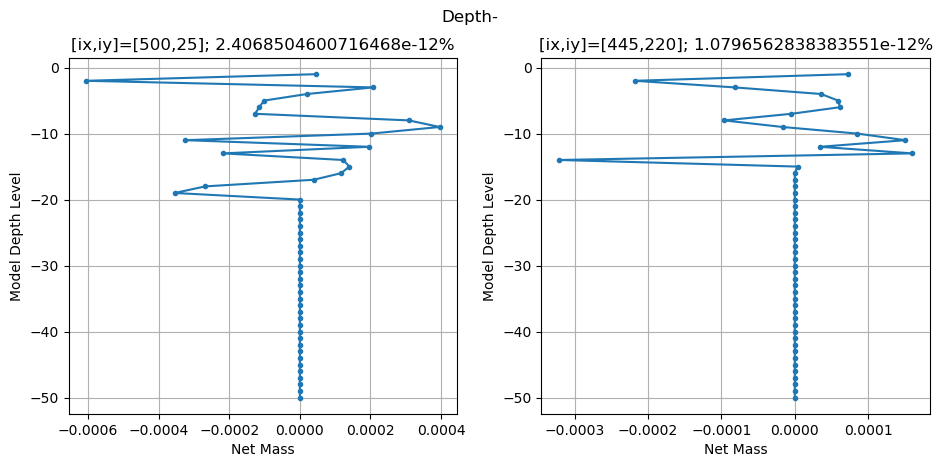

In [30]:
# Figure 1
plt.figure(1, figsize=(9.5, 8.5))
aa = np.zeros((nz, 4))
plt.suptitle("Depth-")

# four figures labeled n
for n in range(1, 3):
    ix, iy, k = pt[n-1]
    aa[:, n-1] = budgO['fluxes']['tend'][:, iy, ix] - budgO['fluxes']['zconv'][:, iy, ix] - budgO['fluxes']['hconv'][:, iy, ix]
    #aa[:, n-1] = budgO['tend'][iy, ix] - budgO['hconv'][0,iy, ix] - budgO['zconv'][iy, ix]

    plt.subplot(2, 2, n)
    plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
    plt.grid()
    #plt.xlabel(f"net budg{strbudg[0]}o")
    plt.xlabel("Net Mass")
    plt.ylabel("Model Depth Level")
    plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['fluxes']['zconv'][:,iy, ix]))}%")
        
plt.tight_layout()
plt.show()

In [31]:
a = budgO['fluxes']['tend'] * np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))
b = budgO['fluxes']['hconv'] * np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))
c = budgO['fluxes']['zconv'] * np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))

a[np.isnan(a)] = 0
b[np.isnan(b)] = 0
c[np.isnan(c)] = 0

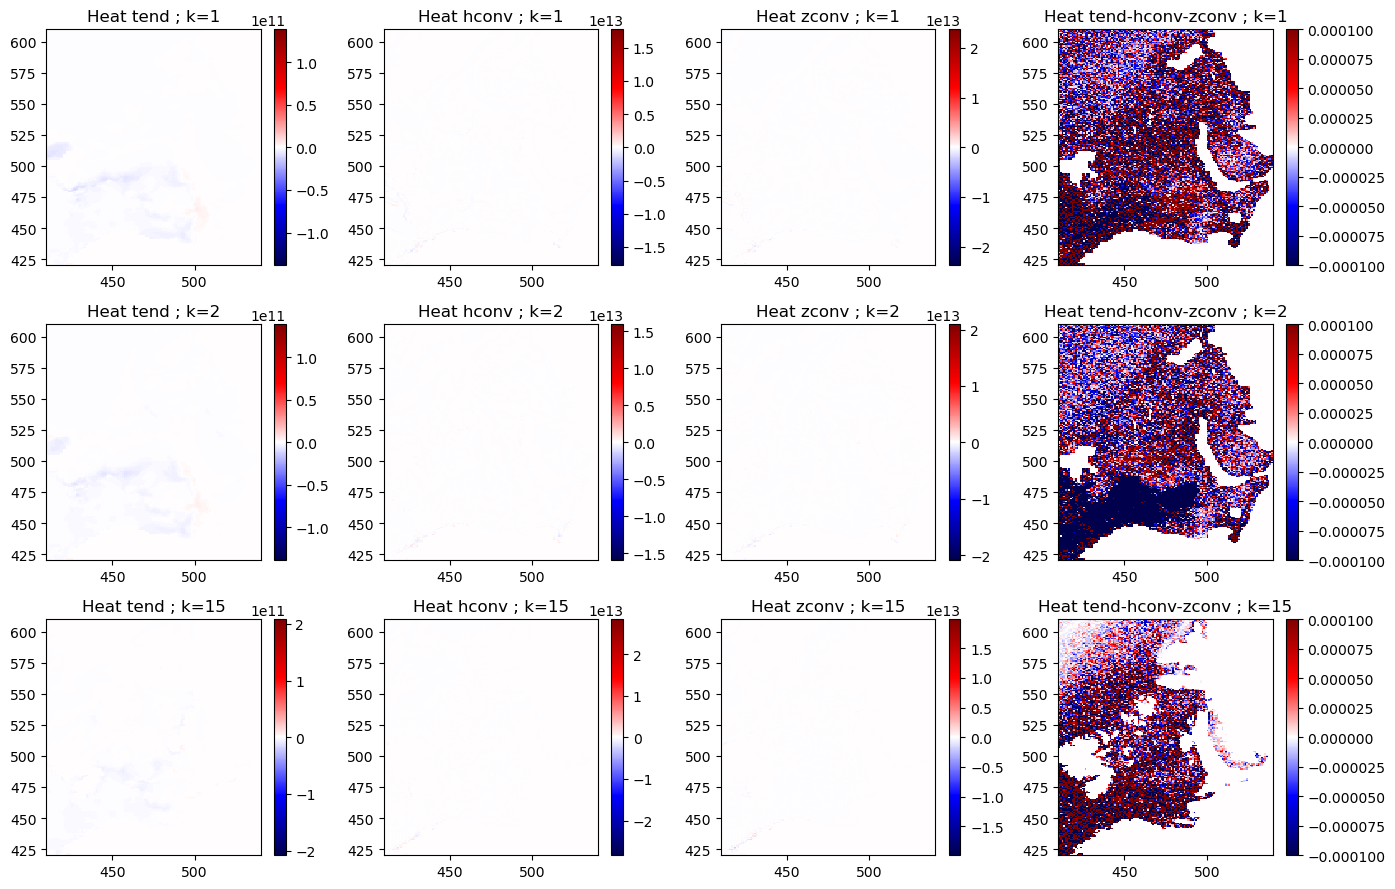

In [32]:
# Figure 2


klev = [1, 2, 15]
fig, axes = plt.subplots(3, 4, figsize=(14, 9))

for idx, k1 in enumerate(klev):
    str_k = f"; k={k1}"
    fourth = 1
    for j, (data, title) in enumerate([(a, 'tend'), (b, 'hconv'), (c, 'zconv'), (a-b-c, 'tend-hconv-zconv')]):
        ax = axes[idx, j]
        mydata = get_aste_tracer(data[k1-1,:, :],nfx,nfy)[0]
        #mydata = data[k1-1,:, :]
        if fourth == 4:
            pcm = ax.pcolormesh(mydata, cmap='seismic', vmin=-1e-4, vmax=1e-4)
        else:
            pcm = ax.pcolormesh(mydata, cmap='seismic', vmin=-0.99*abs(data[k1-1,:, :].max()), vmax=0.99*abs(data[k1-1,:, :].max()))
        fig.colorbar(pcm, ax=ax)

        #ax.scatter(get_aste_tracer(np.array([[533],[56]]),nfx,nfy)[0])
    
        ax.set_title(f"{strbudg} {title} {str_k}")
        ax.set_xlim(410,540)
        ax.set_ylim(420,610)

        fourth += 1

plt.tight_layout()
# plt.savefig(f"{dirOut}{strbudg}_budget2_{t2:010}.png")
plt.show()

# do a single point comparison to prove that this is budgeted

In [33]:
# do the surface, bottom and one other point
x = pt[0][0]
y = pt[0][1]
z = 0    # also do 5, 18 (or 17)

print(x,y,z)

25 500 0


In [34]:
# do the point breakdown
a = (budgO['fluxes']['tend'][z, y, x])
b = (budgO['fluxes']['zconv'][z, y, x])
c = (budgO['fluxes']['hconv'][z, y, x])
print(a,b,c,a-b-c)

-258649039.62454134 -25145956223.2753 24887307183.65071 4.57763671875e-05


In [35]:
# test to see if we at least get the same thing as with the single cell An runthrough

# whenever this is budgeted then we can create the vectors

In [53]:
# we have budgO['fluxes']['ADV_hconv'] and ...['DF_hconv'] which are the hconv components from each
# budgO['fluxes'][ADV_Tconv] and ...[DF_Tconv]
# budgO['fluxes']['KPP_Tconv']
# swtop
# if we look at the surface, we should have Ttend - ADV


# for the surface!!
x = pt[0][0]
y = pt[0][1]
z = 0    # also do 5, 18 (or 17)

print(z,y,x)
print()

# do a tester cell
ctend = budgO['fluxes']['tend'][z,y,x]               # J/s
cadvtconv = budgO['fluxes']['ADV_Tconv'][z,y,x]      # J/s
cdftconv = budgO['fluxes']['DF_Tconv'][z,y,x]        # J/s
ckppconv = budgO['fluxes']['KPP_Tconv'][z,y,x]       # J/s  
czconv = zconv_top[y,x]
cswtop = swtop[z+1,y,x]
# cswtop = swtop[z+1,y,x] - swtop[z,y,x]

print(ctend)
print(cadvtconv)
print(cdftconv)
print(czconv)
print(ckppconv)
print(cswtop)
print()

vectorconv = ctend - cadvtconv - cdftconv - ckppconv - czconv + cswtop
print(vectorconv)

0 500 25

-258649039.62454134
1104090918.6691513
16994377259.92898
-22639759187.446136
6652951667.3253355
2370309698.101918

4.673004150390625e-05


In [44]:
# we have budgO['fluxes']['ADV_hconv'] and ...['DF_hconv'] which are the hconv components from each
# budgO['fluxes'][ADV_Tconv] and ...[DF_Tconv]
# budgO['fluxes']['KPP_Tconv']
# swtop
# if we look at the surface, we should have Ttend - ADV


# for the surface!!
x = pt[0][0]
y = pt[0][1]
z = 7    # also do 5, 18 (or 17)

print(z,y,x)
print()

# do a tester cell
ctend = budgO['fluxes']['tend'][z,y,x]               # J/s
cadvtconv = budgO['fluxes']['ADV_Tconv'][z,y,x]      # J/s
cdftconv = budgO['fluxes']['DF_Tconv'][z,y,x]        # J/s
ckppconv = budgO['fluxes']['KPP_Tconv'][z,y,x]       # J/s  

# I think the following need to change based on the fraction with depth
czconv = zconv_top[y,x]
cswtop = swtop[z+1,y,x] - swtop[z,y,x]

print(ctend)
print(cadvtconv)
print(cdftconv)
# print(czconv)
print(ckppconv)
print(cswtop)
print()

vectorconv = ctend - cadvtconv - cdftconv - ckppconv + cswtop
print(vectorconv)

7 500 25

-235723546.32709616
59427485.85258627
-484551020.41513157
142930595.61860275
-46469392.61653584

0.00031054019927978516


In [48]:
# now we can plot these the same way as we did for salt
# Data variables (as given in your initial code)
a = budgO['fluxes']['tend']
b = budgO['fluxes']['ADV_Tconv']
c = budgO['fluxes']['DF_Tconv']
d = budgO['fluxes']['KPP_Tconv']
e = zconv_top.reshape(1,ny,nx)                 # NOTE - this is only at the surface
f = swtop

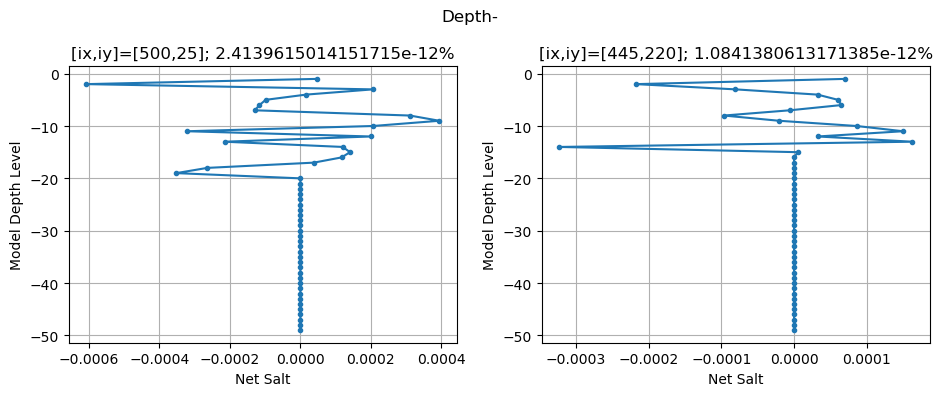

In [56]:
# show the convergence of heat at depth - I will make this a 1 by 2 plot so I can look at things easier
plt.figure(figsize=(9.5, 4))

aa = np.zeros((nz, 2))
plt.suptitle("Depth-")

n = 1
ix, iy, k = pt[n-1]
aa[:, n-1] = (a[:, iy, ix] - b[:, iy, ix] - c[:, iy, ix] - d[:, iy, ix])
aa[1:-1, n-1] += (f[2:,iy,ix] - f[1:-1,iy,ix])    # for swtop we want the difference between the top and bottom
aa[0, n-1] += f[1,iy,ix]
aa[0, n-1] -= zconv_top[iy, ix]      # subtract the TFLUX at the surface only
plt.subplot(1, 2, n)
plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
plt.grid()
plt.xlabel("Net Salt")
plt.ylabel("Model Depth Level")
plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['fluxes']['zconv'][:,iy, ix]))}%")

n = 2
ix, iy, k = pt[n-1]
aa[:, n-1] = a[:, iy, ix] - b[:, iy, ix] - c[:, iy, ix] - d[:, iy, ix]
aa[1:-1, n-1] += (f[2:,iy,ix] - f[1:-1,iy,ix])
aa[0, n-1] += f[1,iy,ix]
aa[0, n-1] -= zconv_top[iy, ix]                   # this is because we already included the TFLUX
plt.subplot(1, 2, n)
plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
plt.grid()
plt.xlabel("Net Salt")
plt.ylabel("Model Depth Level")
plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['fluxes']['zconv'][:,iy, ix]))}%")
    
        
plt.tight_layout()
plt.show()